In [1]:
# ! pip install python-gdcm
# ! pip install pylibjpeg pylibjpeg-libjpeg pydicom pylibjpeg-openjpeg

In [2]:
import wandb
from datetime import datetime

In [3]:
lr = 1e-3
batch_size = 16
wd = 1e-5
pos_weight = 20
mse_weight = 50  # relative to classification error
image_size = 512
backbone="resnet50"

In [4]:
wandb_entity='longyi'
model_name = "detection"
wandb.init(project="cervical-spine", entity=wandb_entity, config={
    "model":model_name,
    "batch_size":batch_size,
    "lr" : lr,
    "wd" : wd,
    "pos_weight" : pos_weight,
    "mse_weight" : mse_weight,
    "backbone" : backbone,
    "image_size" : image_size,
})
wandb.run.name = f'sagittal_segmentation_{model_name}_' + datetime.now().strftime("%H%M%S")
wandb.run.name

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: longyi. Use `wandb login --relogin` to force relogin


'sagittal_segmentation_detection_222641'

In [5]:
import os
import glob
import pydicom
import nibabel as nib
import pandas as pd
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from tqdm import tqdm

from PIL import Image, ImageOps

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop
import torchvision.transforms.functional as TF

In [7]:
# DATA_DIR = "/media/longyi/SSD9701/"
# DATA_DIR = "/Volumes/SSD970/"
DATA_DIR = "/root/autodl-tmp/dataset/cervical_spine/"
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, "train_images")

SAGITTAL_IMAGES_DIR = os.path.join(DATA_DIR, "segmentation_sagittal_images")
SAGITTAL_LABEL_DIR = os.path.join(DATA_DIR, "segmentation_sagittal_labels")

In [8]:
seg_df = pd.read_csv(os.path.join(DATA_DIR, 'meta_segmentation_sagittal.csv'))
seg_df = seg_df.set_index(['UID'])
seg_df.head()

,sagittal_index,z_spacing,pixel_spacing,aspect,width,height,is_flip
UID,,,,,,,
1.2.826.0.1.3680043.10633,0,0.5,0.285156,1.753425,512,752,0
1.2.826.0.1.3680043.10633,1,0.5,0.285156,1.753425,512,752,0
1.2.826.0.1.3680043.10633,2,0.5,0.285156,1.753425,512,752,0
1.2.826.0.1.3680043.10633,3,0.5,0.285156,1.753425,512,752,0
1.2.826.0.1.3680043.10633,4,0.5,0.285156,1.753425,512,752,0


In [9]:
seg_df.iloc[0]

sagittal_index      0.000000
z_spacing           0.500000
pixel_spacing       0.285156
aspect              1.753425
width             512.000000
height            752.000000
is_flip             0.000000
Name: 1.2.826.0.1.3680043.10633, dtype: float64

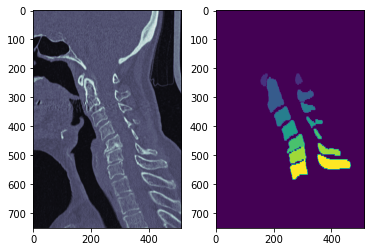

In [10]:
_, axs = plt.subplots(1, 2)

sagittal_img = Image.open(os.path.join(SAGITTAL_IMAGES_DIR, seg_df.iloc[0].name, f"254.jpeg"))
axs[0].imshow(sagittal_img, cmap='bone')

sagittal_label = Image.open(os.path.join(SAGITTAL_LABEL_DIR, seg_df.iloc[0].name, f"254.png"))
axs[1].imshow(sagittal_label)

In [11]:
np.unique(np.asarray(sagittal_label))

array([  0,  32,  64,  96, 128, 160, 192, 224], dtype=uint8)

In [12]:

class SegSagittalDataset(Dataset):
    def __init__(self, df, image_dir, seg_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.seg_dir = seg_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sagittal_df = self.df.iloc[idx]
        UID = sagittal_df.name

        sagittal_index = int(sagittal_df.sagittal_index)

        slice_img = Image.open(os.path.join(self.image_dir, UID, f"{sagittal_index}.jpeg"))

        label_img = Image.open(os.path.join(self.seg_dir, UID, f"{sagittal_index}.png"))
        # label_img = np.round(np.asarray(label_img, np.uint8) // 32)
        if self.transform:
            slice_img, label_img = self.transform(slice_img, label_img)

        return slice_img, label_img

In [13]:
total_slices = np.arange(len(seg_df))
np.random.shuffle(total_slices)
train_indices, val_indices = total_slices[:-3000], total_slices[-3000:]
train_df = seg_df.iloc[train_indices]
val_df = seg_df.iloc[val_indices]
train_df.head()

,sagittal_index,z_spacing,pixel_spacing,aspect,width,height,is_flip
UID,,,,,,,
1.2.826.0.1.3680043.32658,250,0.500,0.289062,1.729730,512,577,0
1.2.826.0.1.3680043.5002,335,0.500,0.390625,1.280000,512,510,0
1.2.826.0.1.3680043.5002,170,0.500,0.390625,1.280000,512,510,0
1.2.826.0.1.3680043.32436,387,0.625,0.332031,1.882354,512,510,0
1.2.826.0.1.3680043.8574,254,1.000,0.367188,2.723404,512,656,0


In [14]:
class DataTransform(nn.Module):
    def __init__(self):
        super().__init__()

        self.transform = T.Compose([
            T.Resize(image_size),
            T.RandomAutocontrast(),
            T.ToTensor(),
            T.Normalize(0.5, 0.5)
        ])

        self.target_transform = T.Compose([
            T.Resize(image_size, interpolation=torchvision.transforms.InterpolationMode.NEAREST),
            T.PILToTensor(),
            T.Lambda(lambda x: x.float()),
            T.Normalize(0, 256)
        ])

    def forward(self, x, y):
        x = TF.center_crop(x, max(x.width, x.height))
        x = self.transform(x)

        y = TF.center_crop(y, max(y.width, y.height))
        y = self.target_transform(y)

        return x, y

transform = DataTransform()

In [15]:
train_dataset = SegSagittalDataset(train_df, SAGITTAL_IMAGES_DIR, SAGITTAL_LABEL_DIR, transform=transform)
val_dataset = SegSagittalDataset(val_df, SAGITTAL_IMAGES_DIR, SAGITTAL_LABEL_DIR, transform=transform)

In [16]:
x, y = train_dataset[100]
print(f"{x.shape} {y.shape}")

torch.Size([1, 512, 512]) torch.Size([1, 512, 512])


In [17]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=min(batch_size, os.cpu_count()))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=min(batch_size, os.cpu_count()))

tensor(0.0003)


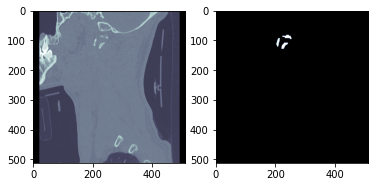

In [18]:

x, y = val_dataset[70]
_, axs = plt.subplots(1, 2)
axs[0].imshow(x.squeeze(), cmap='bone')
axs[1].imshow(y.squeeze(), cmap='bone')
print(y.mean())

In [19]:
print(x.min())
print(x.max())
print(y.min())
print(y.max())

tensor(-1.)
tensor(1.)
tensor(0.)
tensor(0.1250)


In [20]:
y

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

## Model

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [22]:
class DetectionModel(nn.Module):
    def __init__(self, backbone, channels, deep=4, out_channels=64, n_features=1):
        super().__init__()

        self.backbone = backbone
        self.deep = deep
        self.channels = channels
        self.out_channels = out_channels
        self.n_features = n_features

        self.init_layers()

    def init_layers(self):
        self.parallel_modules = self.make_parallel_modules()
        self.upsampling_modules = self.make_upsampling_modules()

        self.downsampling_modules = self.make_downsampling_modules()
        self.classification_modules = self.make_classification_modules()

    def make_classification_modules(self):
        # the last layer
        return nn.Sequential(
            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.out_channels, self.n_features, kernel_size=1, padding='same'),
            #             nn.AdaptiveMaxPool2d(output_size=(None, 1))
        )

    def make_parallel_modules(self):
        parallel_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Conv2d(self.channels[i], self.channels[i], kernel_size=3, padding='same')
            parallel_modules.append(module)


        return parallel_modules

    def make_downsampling_modules(self):
        return nn.ModuleList([
            nn.Sequential(
                self.backbone.conv1,
                self.backbone.bn1,
                self.backbone.relu,
                self.backbone.maxpool),
            nn.Sequential(
                self.backbone.layer1,
                self.backbone.layer2,
            ),
            self.backbone.layer3,
            self.backbone.layer4
        ])

    def make_upsampling_modules(self):
        upsampling_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Sequential(
                nn.ReLU(inplace=True),
                nn.Conv2d(self.channels[i], self.channels[i-1] if i > 0 else self.out_channels, kernel_size=1),
                nn.ReLU(inplace=True),
                nn.Upsample(scale_factor=2)
            )
            upsampling_modules.append(module)

        return upsampling_modules



    def forward(self, x):

        downsampling_outputs = []
        out = x
        for module in self.downsampling_modules:
            out = module(out)
            downsampling_outputs.append(out)

        parallel_outputs = []
        for i in range(len(self.parallel_modules)):
            module = self.parallel_modules[i]
            out = module(downsampling_outputs[i])
            parallel_outputs.append(out)

        out = 0
        for i in range(len(self.upsampling_modules)):
            module = self.upsampling_modules[-(i+1)]
            parallel_output = parallel_outputs[-(i+1)]

            up_input = out + parallel_output
            out = module(up_input)

        out = self.classification_modules(out)

        return out

# backbone = resnet18_gray()
# model = DetectionModel(backbone, channels=[64, 128, 256, 512], out_channels=64, n_features=1)

# input = torch.randn(1, 1, 512, 512)
# model(input).shape

In [23]:
import torchvision.models as models

def resnet18_gray():
    model = models.resnet18(pretrained=True)
    conv1_weight = model.conv1.weight
    conv1_weight = conv1_weight.mean(dim=1).unsqueeze(1)

    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=1, padding='same', bias=False)
    model.conv1.weight = nn.Parameter(conv1_weight, requires_grad=True)

    return model

def resnet50_gray():
    model = models.resnet50(pretrained=True)
    conv1_weight = model.conv1.weight
    conv1_weight = conv1_weight.mean(dim=1).unsqueeze(1)

    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=1, padding='same', bias=False)
    model.conv1.weight = nn.Parameter(conv1_weight, requires_grad=True)

    return model

In [24]:
if backbone == 'resnet18':
    backbone = resnet18_gray()
    channels = [64, 128, 256, 512]

elif backbone == 'resnet50':
    backbone = resnet50_gray()
    channels = [64, 512, 1024, 2048]


model = DetectionModel(backbone, channels=channels, out_channels=channels[0], n_features=2).to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params

77833514

In [25]:
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
scaler = torch.cuda.amp.GradScaler(enabled=(device == 'cuda'))

In [26]:
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15, 20], gamma=0.5)


In [27]:
def loss_fn(logits, y, pos_weight=1, mse_weight=1):

    classification_logits, mse_score = logits.chunk(2, dim=1)

    classification_y = y.gt(0).float()

    classification_loss = F.binary_cross_entropy_with_logits(classification_logits, classification_y, pos_weight=torch.tensor(pos_weight))

    mse_loss = classification_y * F.mse_loss(mse_score.sigmoid(), y, reduction='none')
    mse_loss = mse_weight * mse_loss.mean()


    return classification_loss, mse_loss

In [28]:
def train_one_epoch(e, model, dataloader):

    model.train()
    train_iter = tqdm(dataloader)
    losses = []
    epoch_iteration = len(dataloader)

    for i, (x, y) in enumerate(train_iter):
        x = x.to(device)
        y = y.to(device)

        with torch.cuda.amp.autocast(device == 'cuda'):
            logits = model(x)
            c_loss, m_loss = loss_fn(logits, y, pos_weight=pos_weight, mse_weight=mse_weight)
            loss = c_loss + m_loss

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # optimizer.step()

        train_iter.set_description(f"t {e} loss {loss.item():.4f} c {c_loss.item():.4f} m {m_loss.item():.4f}")

        losses.append(loss.item())


        if wandb.run is not None:
            lr_logs = {f"last_lr_{i}": float(v) for i, v in enumerate(scheduler.get_last_lr())}
            wandb.log({
                'train_loss' : loss.item(),
                'train_classification_loss' : c_loss.item(),
                'train_mse_loss' : m_loss.item(),
                'epoch' : e,
                'train_iteration' : i + e * epoch_iteration,
                **lr_logs,
            })

        if i % 100 == 0:
            with torch.no_grad():
                inference(model, val_dataset)
            model.train()

    return np.mean(losses)

In [29]:
def evaluate(e, model, dataloader):

    model.eval()
    eval_iter = tqdm(dataloader)
    losses = []
    epoch_iteration = len(dataloader)

    for i, (x, y) in enumerate(eval_iter):
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        c_loss, m_loss = loss_fn(logits, y)
        loss = c_loss + m_loss

        eval_iter.set_description(f"e {e} loss {loss.item():.4f}")

        losses.append(loss.item())

        if wandb.run is not None:
            wandb.log({
                'val_loss' : loss.item(),
                'val_classification_loss' : c_loss.item(),
                'val_mse_loss' : m_loss.item(),
                'epoch' : e,
                'val_iteration' : i + e * epoch_iteration,
            })

    return np.mean(losses)

In [30]:
def color_image(gray_img, cmap='bone'):
    # 'nipy_spectral'
    cm = plt.get_cmap(cmap)
    colored_image = cm(gray_img)
    return colored_image

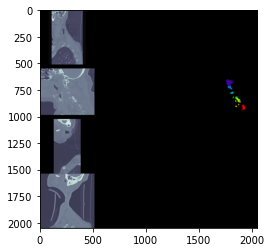

In [31]:
def inference(model, dataset, i_list=None, wandb_log=True):
    model.eval()
    if i_list is None:
        i_list = np.random.choice(len(dataset) - 1, 4)
    x_list = []
    y_list = []
    for i in i_list:
        x, y = dataset[i]
        x_list.append(x)
        y_list.append(y)
    x, y = torch.stack(x_list), torch.stack(y_list)

    x = x.to(device)
    logits = model(x)
    classification_logits, mse_score = logits.chunk(2, dim=1)
    classification_pred = classification_logits.sigmoid().gt(0.5).float()
    mse_pred = (classification_pred * mse_score.sigmoid()).squeeze().cpu().numpy()

    img = x * 0.5 + 0.5
    
    img = color_image(img.squeeze().cpu().numpy())
    classification_pred = color_image(classification_pred.squeeze().cpu().numpy())
    
    mse_pred = np.round(mse_pred * 8) / 8
    mse_pred = color_image(mse_pred, cmap='nipy_spectral')
    
    y = color_image(y.squeeze().cpu().numpy(), cmap='nipy_spectral')
    
    combined_img = np.concatenate((img, classification_pred, mse_pred, y), axis=2)
    combined_img = combined_img.reshape(-1, combined_img.shape[2], combined_img.shape[3])
    
    if wandb_log is True and wandb.run is not None:
        wandb.log({
            'val_img_pred_label' : wandb.Image(combined_img),
        })
    if wandb_log is False:
        plt.imshow(combined_img)
        plt.show()

with torch.no_grad():
    inference(model, val_dataset, wandb_log=False)

In [32]:
epoch = 0

In [33]:
epochs = 20

for e in range(epochs):

    train_loss = train_one_epoch(epoch, model, train_loader)

    with torch.no_grad():
        eval_loss = evaluate(epoch, model, val_loader)
        inference(model, val_dataset)

    print(f"epoch {epoch} train_loss {train_loss} eval_loss {eval_loss}")

    epoch += 1
    scheduler.step()

t 0 loss 0.0829 c 0.0684 m 0.0145:  25%|██▌       | 651/2595 [07:39<22:52,  1.42it/s]


KeyboardInterrupt: 

In [ ]:
state = {
    "model": model.state_dict(),
    "optimizer": optimizer.state_dict(),
    "scheduler": scheduler.state_dict(),
    "epoch": epoch,
}
torch.save(state, f'{wandb.run.name}-epoch-{epoch}.pth')